# Generate Atari Game frames with Generative Adversarial Neural Networks - Ignite version

## References
* [(Lapan, 2020), Deep Reinforcement Learning Hands-On Second Edition](https://www.amazon.com/Deep-Reinforcement-Learning-Hands-optimization/dp/1838826998/ref=sr_1_1?keywords=deep+reinforcement+learning+hands-on&qid=1648904999&sprefix=deep+reinfor%2Caps%2C261&sr=8-1)
    * [Github](https://github.com/PacktPublishing/Deep-Reinforcement-Learning-Hands-On-Second-Edition/blob/master/Chapter03/03_atari_gan.py)
* [(Goodfellow, 2014) Generative adversarial nets](https://arxiv.org/abs/1406.2661?source=post_page-----b665bbae3317----------------------)

This notebook depics a GAN architecture to generate Atari game frames. For three selected games, we are going to generate frames using a random agent policy and train a GAN to generate realistic frames from those video games.

A GAN architecture contains two different networks competing with each other:
* A Generator $G(z, \theta_g)$, which from random noise can generate fake tensors of the same dimensions of the expected output. In case of images it can be used a Transconvolution, i.e., the inverse of the convolutional process. This network is trained with the aim to fool a *discriminator* making it beleave the fake output is genuine. 
* A Discriminator $D(x, \theta_d)$ that is trained specifically to distinguish between real and fake inputs.

## Requirements
1. Create the conda environment using the provided `environment.yaml` file.
2. **Important:** decode this, download and place them where it can be used :wink: : `aHR0cDovL3d3dy5hdGFyaW1hbmlhLmNvbS9yb21fY29sbGVjdGlvbl9hcmNoaXZlX2F0YXJpXzI2MDBfcm9tcy5odG1sCg==` 

In [1]:
!mkdir -p ./roms
!ale-import-roms roms/

[SUPPORTED]                 air_raid               roms/airraid.bin
[SUPPORTED]                 breakout              roms/breakout.bin
[SUPPORTED]                     pong                  roms/pong.bin



Imported 3 / 3 ROMs


In [2]:
import cv2
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torchvision.utils as tvutils
import gym
import gym.spaces
import numpy as np
from ignite.engine import Engine, Events
from ignite.metrics import RunningAverage
from ignite.contrib.handlers import tensorboard_logger as tb_logger

logger = gym.logger
logger.set_level(gym.logger.INFO)

IMAGE_SIZE = 64

This is a simple wrapper around gym environments to transform the observation for model training. Image resize and channel transpose.

In [3]:
class InputWrapper(gym.ObservationWrapper):

    def __init__(self, *args):
        super(InputWrapper, self).__init__(*args)
        assert isinstance(self.observation_space, gym.spaces.Box)
        old_space = self.observation_space
        self.observation_space = gym.spaces.Box(
            self.observation(old_space.low),
            self.observation(old_space.high),
            dtype=np.float32
        )

    def observation(self, observation):
        new_obs = cv2.resize(observation, (IMAGE_SIZE, IMAGE_SIZE))
        # W x H X C -> C x W x H
        new_obs = np.transpose(new_obs, [2, 0, 1])
        return new_obs.astype(np.float32)



### Discriminator $D(x, \theta_d)$
First we define the discriminator. It can be of any architecture, in this case since we are dealing with images, we define a convolutional architecture. What is important is that the output should be binary that signals if the input is true or fake, so the last activation should be a $\mathrm{sigmoid(x)}$.

In [4]:
class Discriminator(nn.Module):
    def __init__(self, input_shape, filters):
        super(Discriminator, self).__init__()
        self.conv_pipe = nn.Sequential(
            nn.Conv2d(in_channels=input_shape[0], out_channels=filters, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=filters, out_channels=filters * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(filters * 2),
            nn.ReLU(),
            nn.Conv2d(in_channels=filters * 2, out_channels=filters * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(filters * 4),
            nn.ReLU(),
            nn.Conv2d(in_channels=filters * 4, out_channels=filters * 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(filters * 8),
            nn.ReLU(),
            nn.Conv2d(in_channels=filters * 8, out_channels=1, kernel_size=4, stride=1, padding=0),
            nn.Flatten()
            # nn.Sigmoid()
        )

    def forward(self, x):
        conv_out = self.conv_pipe(x)
        return conv_out.view(-1, 1).squeeze(dim=1)

### Generator $G(z, \theta_g)$
The generator can start from a random noise prior $p_g(z)$ and transform it till we obtain a tensor with the same dimensions as the original expected outputs, e.g., images. So we make use of `ConvTranspose` to basically inverse the convolution process.

In [5]:
class Generator(nn.Module):
    def __init__(self, output_shape, latent_vec_size, filters):
        super(Generator, self).__init__()
        self.pipe = nn.Sequential(
            nn.ConvTranspose2d(in_channels=latent_vec_size, out_channels=filters * 8, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(filters * 8),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=filters * 8, out_channels=filters * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(filters * 4),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=filters * 4, out_channels=filters * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(filters * 2),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=filters * 2, out_channels=filters, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(filters),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=filters, out_channels=output_shape[0], kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.pipe(x)

This function simply will play the games in the envs with a random policy agent till fills up a buffer for the batch size and returns it as a tensor from which both the Generator and Discriminator will train.

In [6]:
def generate_batch(envs, batch_size):
    batch = [e.reset() for e in envs]
    env_gen = iter(lambda: random.choice(envs), None)
    while True:
        e = next(env_gen)
        obs, reward, is_done, _ = e.step(e.action_space.sample())
        if np.mean(obs) > 0.01:
            batch.append(obs)
        if len(batch) == batch_size:
            batch_np = np.array(batch, dtype=np.float32) * 2.0 / 255.0 - 1.0 # Normalize values
            return torch.tensor(batch_np)
        if is_done:
            e.reset()

def generate_dataset(envs, total_batches, batch_size):
    b_count = 0
    while b_count < total_batches:
        yield generate_batch(envs, batch_size)
        b_count += 1

### Preparations
Below we do several things:
1. Prepare the environments 
2. Define the input shape, which should be dimensions of a game frame: `C x W x H`. And the `latent_vector_space` which is basically the size of the noise prior to be feed into the generator.
3. Define the Discriminator & Generator networks
4. Define the loss. The training revolves about the discriminator, which output is binary, hence we define a `Binary Cross Entropy Loss`.
5. Define separate optimizers for both networks
6. Define auxiliarly structures.
7. Define labels for the discriminator. The way we train $D$ is by comparing its output testing if its fake or real, so we just need two dummies for that. When we compute the loss of $D$, we always know when we feed a real or fake so we use these dummies to compute the loss.  

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# 1
games = ['ALE/Breakout-v5', 'ALE/AirRaid', 'ALE/Pong']
envs = [InputWrapper(gym.make(env_name)) for env_name in games]

#2
input_shape = envs[0].observation_space.shape
latent_vector_size = 100

#3
net_discriminator = Discriminator(input_shape, filters=64).to(device)
net_generator = Generator(output_shape=input_shape, filters=64, latent_vec_size=latent_vector_size).to(device)

#4
discriminator_loss = nn.BCEWithLogitsLoss()
learing_rate = 1e-3
#5
disc_optimizer = optim.Adam(net_discriminator.parameters(), lr=learing_rate, betas=(0.5, 0.999))
gen_optimizer = optim.Adam(net_generator.parameters(), lr=learing_rate, betas=(0.5, 0.999))

gen_losses = []
disc_losses = []
batch_size = 32

#7
true_labels_v = torch.zeros(batch_size, device=device)
fake_labels_v = torch.ones(batch_size, device=device)

INFO: Making new env: ALE/Breakout-v5
A.L.E: Arcade Learning Environment (version 0.7.4+069f8bd)
[Powered by Stella]
/home/luis-ferro/miniconda3/envs/gan-pytorch/lib/python3.9/site-packages/gym/utils/seeding.py:138: DeprecationWarning: WARN: Function `hash_seed(seed, max_bytes)` is marked as deprecated and will be removed in the future. 
  deprecation(
/home/luis-ferro/miniconda3/envs/gan-pytorch/lib/python3.9/site-packages/gym/utils/seeding.py:175: DeprecationWarning: WARN: Function `_bigint_from_bytes(bytes)` is marked as deprecated and will be removed in the future. 
  deprecation(
INFO: Making new env: ALE/AirRaid
/home/luis-ferro/miniconda3/envs/gan-pytorch/lib/python3.9/site-packages/gym/envs/registration.py:511: UserWarning: WARN: Using the latest versioned environment `ALE/AirRaid-v5` instead of the unversioned environment `ALE/AirRaid`
  logger.warn(
INFO: Making new env: ALE/Pong
/home/luis-ferro/miniconda3/envs/gan-pytorch/lib/python3.9/site-packages/gym/envs/registration.py

### Training
The training proceeds as follows:
1. Generate a batch from the real games
2. Generate fakes from a random prior
3. **Train Discriminator**: Invoke the discriminator on both, the generated and the real images.
4. The total loss should be the sum of the loss produced by the fakes and the real ones. So the gradient for the discriminator update is: 
$$
\nabla_{\theta_d} \frac{1}{m}\sum_{i=1}^m \begin{bmatrix}
\mathrm{log}D(x^{(i)}) + \mathrm{log}(1 - D(G(z^{(i)})))
\end{bmatrix}
$$
Where $x^{(i)}$ correspond to the $i_{th}$ real $x$ example and similarly $z^{(i)}$ correspond to the $i_{th}$ fake $z$ counterpart.
**IMPORTANT** while computing the discriminator loss for the fakes we need to `detach` the output of the generator to avoid computing gradients for this evaluation, otherwise the training can be messed up.
5. **Train Generator**: Invoke again the discriminator on the fake generated image, this time computing the gradients (no `detach`) and calculate the `BCELoss` against true lables, i.e., we are training to make these images 'real' against the discriminator. So the gradient for the generator update is:
$$
\nabla_{\theta_g} \frac{1}{m}\sum_{i=1}^m \mathrm{log}(1 - D(G(z^{(i)})))
$$

In [8]:
def process_batch(trainer, batch):
    # print(f"1={trainer.state.iteration}, 2={trainer.state.epoch_length}, 3={trainer.state.max_epochs}")
    # 2 input tensor shape: batch x latent vec size x 'width' x 'height' as a single value
    gen_input_v = torch.FloatTensor(batch_size, latent_vector_size, 1, 1)
    gen_input_v.normal_(0., .5) # fill tensor with gaussian random with mu=0.0 and sigma=1
    gen_input_v = gen_input_v.to(device)
    batch_v = batch.to(device)
    gen_output_v = net_generator(gen_input_v)

    # 3 train discriminator
    disc_optimizer.zero_grad()
    dis_output_true_v = net_discriminator(batch_v)
    dis_output_fake_v = net_discriminator(gen_output_v.detach())
    dis_loss = discriminator_loss(dis_output_true_v, true_labels_v) + discriminator_loss(dis_output_fake_v, fake_labels_v)
    dis_loss.backward()
    disc_optimizer.step()
    
    disc_losses.append(dis_loss.item())

    # 4 train generator
    gen_optimizer.zero_grad()
    dis_output_v = net_discriminator(gen_output_v)
    gen_loss_v = discriminator_loss(dis_output_v, true_labels_v)
    gen_loss_v.backward()
    gen_optimizer.step()

    # log images every n
    if trainer.state.iteration % 10 == 0:
        indices = np.random.randint(0, batch_size, size=16)
        trainer.tb.writer.add_image("fake", tvutils.make_grid(
            gen_output_v.data[indices], normalize=True
        ), global_step=trainer.state.iteration)
        trainer.tb.writer.add_image("real", tvutils.make_grid(
            batch_v.data[indices], normalize=True
        ), global_step=trainer.state.iteration)
    
    return dis_loss.item(), gen_loss_v.item()

engine = Engine(process_batch)
tb = tb_logger.TensorboardLogger(log_dir='experiments/atari-logs')
engine.tb = tb

RunningAverage(output_transform=lambda out: out[1]).attach(engine, "avg_loss_gen")
RunningAverage(output_transform=lambda out: out[0]).attach(engine, "avg_loss_dis")

out_handler = tb_logger.OutputHandler(
    tag="train",
    metric_names=['avg_loss_gen', 'avg_loss_dis']
)
dis_grad_hist_handler = tb_logger.GradsHistHandler(
    net_discriminator,
    tag="grads/discriminator"
)
gen_grad_hist_handler = tb_logger.GradsHistHandler(
    net_generator,
    tag="grads/generator"
)
tb.attach(
    engine,
    event_name=Events.ITERATION_COMPLETED,
    log_handler=out_handler
)
tb.attach(
    engine,
    event_name=Events.ITERATION_COMPLETED,
    log_handler=dis_grad_hist_handler
)
tb.attach(
    engine,
    event_name=Events.ITERATION_COMPLETED,
    log_handler=gen_grad_hist_handler
)

@engine.on(Events.ITERATION_COMPLETED)
def log_losses(trainer):
    if trainer.state.iteration % 10 == 0:
        gen_loss = trainer.state.metrics['avg_loss_gen']
        dis_loss = trainer.state.metrics['avg_loss_dis']
        logger.info(f"{trainer.state.iteration}, gen_loss={gen_loss:.4f}, dis_loss={dis_loss:.4f}")

In [9]:
%%time
engine.run(data=generate_dataset(envs, 100, batch_size), max_epochs=100)

/home/luis-ferro/miniconda3/envs/gan-pytorch/lib/python3.9/site-packages/torch/utils/tensorboard/summary.py:344: DeprecationWarning: using `dtype=` in comparisons is only useful for `dtype=object` (and will do nothing for bool). This operation will fail in the future.
  cum_counts = np.cumsum(np.greater(counts, 0, dtype=np.int32))
INFO: 10, gen_loss=9.5290, dis_loss=1.2310
INFO: 20, gen_loss=10.0459, dis_loss=1.0310
INFO: 30, gen_loss=9.8946, dis_loss=0.8606
INFO: 40, gen_loss=9.1730, dis_loss=0.8363
INFO: 50, gen_loss=8.6053, dis_loss=0.7009
INFO: 60, gen_loss=8.3013, dis_loss=0.5799
INFO: 70, gen_loss=8.0403, dis_loss=0.7762
INFO: 80, gen_loss=7.3591, dis_loss=0.7579
INFO: 90, gen_loss=6.9008, dis_loss=0.8504


CPU times: user 14min 40s, sys: 11.3 s, total: 14min 51s
Wall time: 2min 15s


INFO: 100, gen_loss=6.2931, dis_loss=0.7994
/home/luis-ferro/miniconda3/envs/gan-pytorch/lib/python3.9/site-packages/ignite/engine/engine.py:821: UserWarning: Data iterator can not provide data anymore but required total number of iterations to run is not reached. Current iteration: 100 vs Total iterations to run : 10000
  warnings.warn(


State:
	iteration: 100
	epoch: 100
	epoch_length: 100
	max_epochs: 100
	output: <class 'NoneType'>
	batch: <class 'NoneType'>
	metrics: <class 'dict'>
	dataloader: <class 'generator'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

Now let's observe the behavior of the losses.

We can observe that the losses tend to be inverse to each other. Whenever the discriminator loss tends to zero, means the discriminator is successfully able to discern fakes vs real images, and when the generator loss decreases, it means the discrimenator generates 'credible' images that the discriminator has a harder time to label as fake (hence its loss increases).

Now let's observe the results

/home/luis-ferro/miniconda3/envs/gan-pytorch/lib/python3.9/site-packages/matplotlib_inline/config.py:66: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


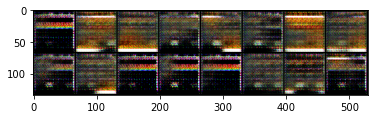

In [10]:
import matplotlib.pyplot as plt

net_generator.eval()
with torch.no_grad():
    gen_input_v = torch.normal(.0, 1., size=(16, latent_vector_size, 1, 1)).to(device)
    gen_output_v = net_generator(gen_input_v)
    generated_images = tvutils.make_grid(gen_output_v.data, normalize=True).cpu().numpy()
    generated_images = np.transpose(generated_images, [1, 2, 0])
    plt.imshow(generated_images)
    plt.show()

Good images start to emerge after 30K epochs (as per book)

In [11]:
torch.save(net_discriminator.state_dict(), './checkpoints/atari-discriminator-v2.cpt')
torch.save(net_generator.state_dict(), './checkpoints/atari-generator-v2.cpt')